In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
from torch_lr_finder import LRFinder

In [ ]:
model = models.vgg16(pretrained=False)
n_classes = 6
n_inputs = model.classifier[-1].in_features
model.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.15),
                                    nn.Linear(256, n_classes),
                                    nn.Sigmoid())

In [2]:
model = models.resnet18(pretrained=False)
n_classes = 6
n_inputs = model.fc.in_features
#for param in model.parameters():  # Freeze feature extractor
#    param.requires_grad = False
model.fc = nn.Sequential(nn.Linear(n_inputs, 64),
                         nn.ReLU(),
                         nn.Dropout(0.15),
                         nn.Linear(64, n_classes),
                         nn.Sigmoid())

In [3]:
from kaishi.image.dataset import ImageDataset
imd = ImageDataset('/home/mwharton/Data/kaishi_image_train_dataset', recursive=True)
imd.configure_pipeline(["FilterInvalidFileExtensions", "FilterInvalidImageHeaders", "FilterDuplicateFiles"])
imd.run_pipeline()

In [4]:
model = model.to('cuda')
steps_per_epoch = 100
data_generator = imd.train_generator(batch_size=16)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1e-4)  # Initialize with dummy LR until we find a better one
n_epochs = 200

In [6]:
def torch_generator():  # Generator that yields torch tensors for lr-finder
    while True:
        x, y = next(data_generator)
        yield torch.cuda.FloatTensor(x), torch.cuda.FloatTensor(y)


Learning rate search finished. See the graph with {finder_name}.plot()


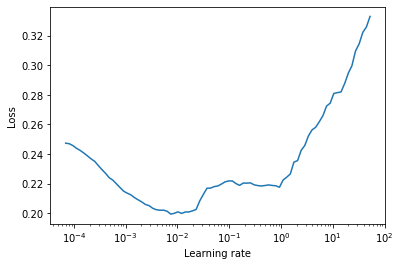

In [7]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(torch_generator(), end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [9]:
optimizer = optim.Adam(model.parameters(), lr=10**-2)

In [10]:
X_val, y_val = imd.generate_validation_data()

In [11]:
minval = 9999

In [ ]:
for epoch in range(n_epochs):
    print('Epoch %3d/%3d' % (epoch + 1, n_epochs))
    running_loss = 0
    lossct = 0
    for step in tqdm(range(steps_per_epoch)):
        optimizer.zero_grad()
        for X, y in data_generator:
            break
        pred = model(torch.from_numpy(X).to(torch.float32).to('cuda'))
        loss = criterion(pred, torch.from_numpy(y).to(torch.float32).to('cuda'))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        lossct += 1
    print('Loss for this epoch: ' + repr(running_loss / float(lossct)))
    val_loss = 0
    for i in range(10):
        Xtmp = X_val[i*32:(i+1)*32]
        ytmp = y_val[i*32:(i+1)*32]
        val_pred = model(torch.from_numpy(Xtmp).to(torch.float32).to('cuda'))
        val_loss += criterion(val_pred, torch.from_numpy(ytmp).to(torch.float32).to('cuda')).item()
    print('Validation loss: ' + repr(val_loss / 10.0))
    if val_loss < minval:
        minval = val_loss
        print('Improved.')
        torch.save(model.state_dict(), 'best_val.pth')

In [17]:
model.load_state_dict(torch.load('best_val.pth'))

<All keys matched successfully>

In [18]:
import matplotlib.pyplot as plt

In [20]:
#pred = model(torch.from_numpy(X_val[:32]).to(torch.float32)).detach().numpy()  # CPU
pred = model(torch.from_numpy(X_val[:10]).to(torch.float32).to('cuda')).cpu().detach().numpy() # GPU

In [ ]:
for i in range(32):
    plt.imshow(np.swapaxes(X_val[i], 0, 2))
    plt.show()
    print('Truth: ' + repr(y_val[i]))
    print('Pred:  ' + repr(pred[i]))

# CLASS LABELS: [DOCUMENT, RECTIFIED, ROTATED_RIGHT, ROTATED_LEFT, UPSIDE_DOWN, STRETCHING]